### Github Social Network Link Prediction

#### Goal: 
- Given a social graph, predict missing links to recommend users

#### Data overview: 
- Taken data from SNAP: http://snap.stanford.edu/data/github-social.html

In [1]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd
import datetime #Convert to unix time
import time #Convert to unix time
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import xgboost as xgb

import networkx as nx
import pdb
import pickle

In [2]:
traincsv = pd.read_csv('musae_git_edges.csv')
print(traincsv[traincsv.isna().any(1)])
print(traincsv.info())
print("Number of diplicate entries: ",sum(traincsv.duplicated()))
traincsv.to_csv('train_woheader.csv',header=False,index=False)
print("Saved the graph into file")

Empty DataFrame
Columns: [id_1, id_2]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289003 entries, 0 to 289002
Data columns (total 2 columns):
id_1    289003 non-null int64
id_2    289003 non-null int64
dtypes: int64(2)
memory usage: 4.4 MB
None
Number of diplicate entries:  0
Saved the graph into file


In [3]:
g=nx.read_edgelist('train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 37700
Number of edges: 289003
Average in degree:   7.6659
Average out degree:   7.6659


Name: 
Type: DiGraph
Number of nodes: 58
Number of edges: 50
Average in degree:   0.8621
Average out degree:   0.8621


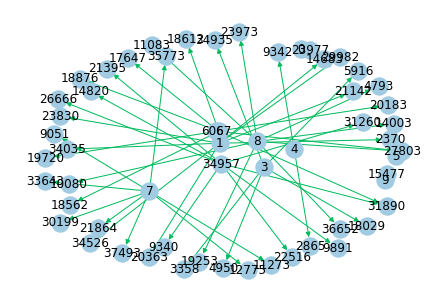

In [4]:
if not os.path.isfile('train_woheader_sample.csv'):
    pd.read_csv('musae_git_edges.csv', nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)
    
subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

#### Exploratory Data Analysis

In [5]:
# No of Unique persons 
print("The number of unique persons",len(g.nodes()))

The number of unique persons 37700


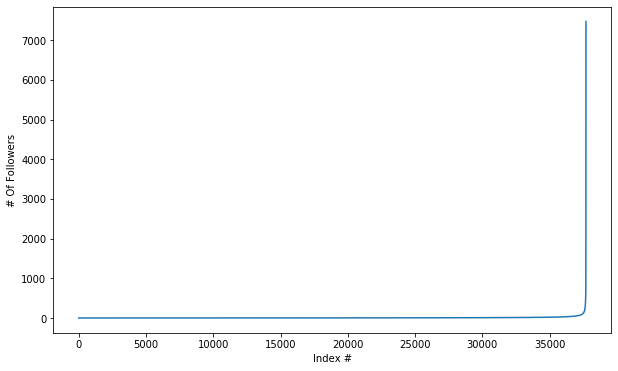

In [6]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index #')
plt.ylabel('# Of Followers')
plt.show()

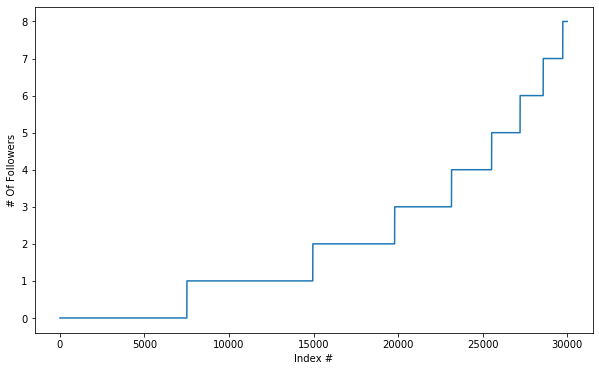

In [7]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:30000])
plt.xlabel('Index #')
plt.ylabel('# Of Followers')
plt.show()

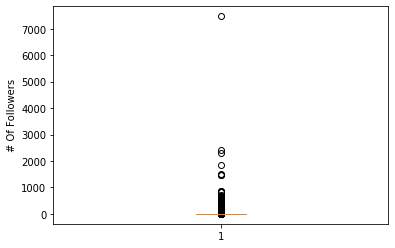

In [8]:
plt.boxplot(indegree_dist)
plt.ylabel('# Of Followers')
plt.show()

In [9]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 15.0
91 percentile value is 16.0
92 percentile value is 18.0
93 percentile value is 20.0
94 percentile value is 23.0
95 percentile value is 26.0
96 percentile value is 31.0
97 percentile value is 38.0
98 percentile value is 50.0
99 percentile value is 77.0
100 percentile value is 7470.0


In [10]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 83.70900000000256
99.2 percentile value is 91.0
99.3 percentile value is 99.10699999999633
99.4 percentile value is 110.0
99.5 percentile value is 126.0
99.6 percentile value is 146.0
99.7 percentile value is 177.0
99.8 percentile value is 231.2039999999979
99.9 percentile value is 389.30100000000675
100.0 percentile value is 7470.0


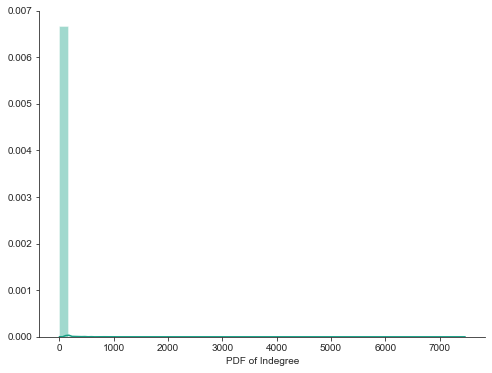

In [11]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()
#plt.show()

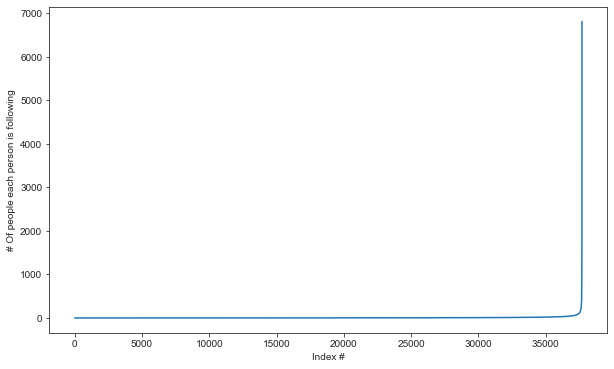

In [12]:
# Number of people each person is following
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index #')
plt.ylabel('# Of people each person is following')
plt.show()

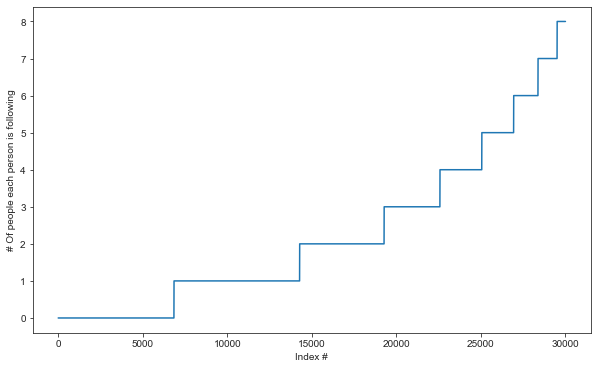

In [13]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:30000])
plt.xlabel('Index #')
plt.ylabel('# Of people each person is following')
plt.show()

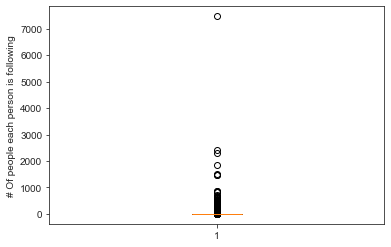

In [14]:
plt.boxplot(indegree_dist)
plt.ylabel('# Of people each person is following')
plt.show()

In [15]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 16.0
91 percentile value is 17.0
92 percentile value is 19.0
93 percentile value is 21.0
94 percentile value is 23.0
95 percentile value is 27.0
96 percentile value is 31.0
97 percentile value is 38.0
98 percentile value is 49.0
99 percentile value is 77.0
100 percentile value is 6809.0


In [16]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 81.0
99.2 percentile value is 87.0
99.3 percentile value is 95.0
99.4 percentile value is 103.0
99.5 percentile value is 114.0
99.6 percentile value is 131.0
99.7 percentile value is 155.0
99.8 percentile value is 216.00999999999476
99.9 percentile value is 351.41800000012154
100.0 percentile value is 6809.0


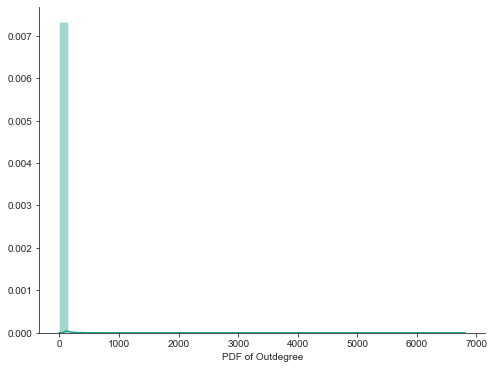

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

In [18]:
print('Number of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
      sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

Number of persons those are not following anyone are 6845 and % is 18.156498673740053


In [19]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('Number of persons those are not not following anyone and also not having any followers are',count)

Number of persons those are not not following anyone and also not having any followers are 0


In [20]:
#Both Follower and Following
from collections import Counter
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

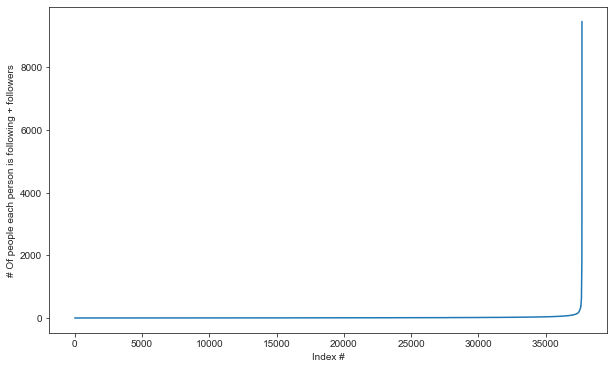

In [21]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index #')
plt.ylabel('# Of people each person is following + followers')
plt.show()

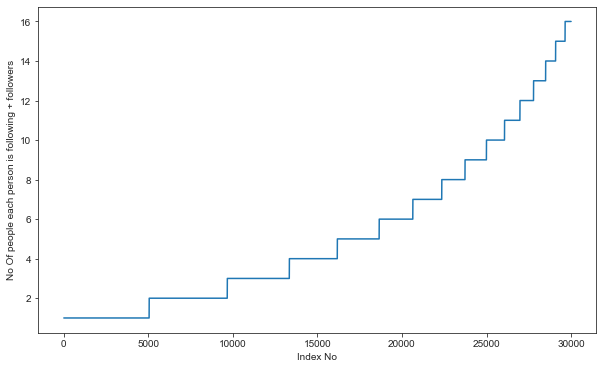

In [22]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:30000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [23]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 30.0
91 percentile value is 32.0
92 percentile value is 35.0
93 percentile value is 39.0
94 percentile value is 44.0
95 percentile value is 50.0
96 percentile value is 58.0
97 percentile value is 71.0
98 percentile value is 91.0
99 percentile value is 138.01000000000204
100 percentile value is 9458.0


In [24]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 148.0
99.2 percentile value is 159.40800000000309
99.3 percentile value is 176.10699999999633
99.4 percentile value is 195.61200000000827
99.5 percentile value is 225.0
99.6 percentile value is 265.0
99.7 percentile value is 311.7089999999953
99.8 percentile value is 401.80599999999686
99.9 percentile value is 644.0300000002026
100.0 percentile value is 9458.0


In [25]:
len(in_out_degree==in_out_degree.min())

37700

In [26]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
5045  persons having minimum no of followers + following


In [27]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 9458
1  persons having maximum no of followers + following


In [28]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 24991


In [29]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components wit 2 nodes',count)

No of weakly connected components 1
weakly connected components wit 2 nodes 0


#### Classsification
+ Generated edges which are not present in graph for supervised learning

In [30]:
r = csv.reader(open('train_woheader.csv','r'))
edges = dict()
for edge in r:
    edges[(edge[0], edge[1])] = 1

In [31]:
%%time
###generating bad edges from given graph
import random
if not os.path.isfile('missing_edges_final.p'):
    #getting all set of edges
    r = csv.reader(open('train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
        
    missing_edges = set([])
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('missing_edges_final.p','rb'))

CPU times: user 2.22 s, sys: 815 ms, total: 3.04 s
Wall time: 3.75 s


In [32]:
missing_edges = pickle.load(open('missing_edges_final.p','rb'))
len(missing_edges)

9437519

- Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [33]:
# Train Test Split
from sklearn.model_selection import train_test_split
if (not os.path.isfile('train_pos_after_eda.csv')) and (not os.path.isfile('test_pos_after_eda.csv')):
    #reading total data df
    df_pos = pd.read_csv('musae_git_edges.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['id_1', 'id_2'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv('train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only 
    del missing_edges

Number of nodes in the graph with edges 289003
Number of nodes in the graph without edges 9437519
Number of nodes in the train data graph with edges 231202 = 231202
Number of nodes in the train data graph without edges 7550015 = 7550015
Number of nodes in the test data graph with edges 57801 = 57801
Number of nodes in the test data graph without edges 1887504 = 1887504


In [34]:
if (os.path.isfile('train_pos_after_eda.csv')) and (os.path.isfile('test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Name: 
Type: DiGraph
Number of nodes: 36449
Number of edges: 231202
Average in degree:   6.3432
Average out degree:   6.3432
Name: 
Type: DiGraph
Number of nodes: 25236
Number of edges: 57801
Average in degree:   2.2904
Average out degree:   2.2904
no of people common in train and test --  23985
no of people present in train but not present in test --  12464
no of people present in test but not present in train --  1251
 % of people not there in Train but exist in Test in total Test data are 4.957203994293866 %


In [35]:
X_train_pos = pd.read_csv('train_pos_after_eda.csv', names=['id_1', 'id_2'])
X_test_pos = pd.read_csv('test_pos_after_eda.csv', names=['id_1', 'id_2'])
X_train_neg = pd.read_csv('train_neg_after_eda.csv', names=['id_1', 'id_2'])
X_test_neg = pd.read_csv('test_neg_after_eda.csv', names=['id_1', 'id_2'])

print('='*60)
print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
print('='*60)
print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

X_train = X_train_pos.append(X_train_neg,ignore_index=True)
y_train = np.concatenate((y_train_pos,y_train_neg))
X_test = X_test_pos.append(X_test_neg,ignore_index=True)
y_test = np.concatenate((y_test_pos,y_test_neg)) 

X_train.to_csv('train_after_eda.csv',header=False,index=False)
X_test.to_csv('test_after_eda.csv',header=False,index=False)
pd.DataFrame(y_train.astype(int)).to_csv('train_y.csv',header=False,index=False)
pd.DataFrame(y_test.astype(int)).to_csv('test_y.csv',header=False,index=False)

Number of nodes in the train data graph with edges 231202
Number of nodes in the train data graph without edges 7550015
Number of nodes in the test data graph with edges 57801
Number of nodes in the test data graph without edges 1887504


In [36]:
#final train and test data sets
if (not os.path.isfile('train_after_eda.csv')) and \
(not os.path.isfile('test_after_eda.csv')) and \
(not os.path.isfile('train_y.csv')) and \
(not os.path.isfile('test_y.csv')) and \
(os.path.isfile('train_pos_after_eda.csv')) and \
(os.path.isfile('test_pos_after_eda.csv')) and \
(os.path.isfile('train_neg_after_eda.csv')) and \
(os.path.isfile('test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('train_pos_after_eda.csv', names=['id_1', 'id_2'])
    X_test_pos = pd.read_csv('test_pos_after_eda.csv', names=['id_1', 'id_2'])
    X_train_neg = pd.read_csv('train_neg_after_eda.csv', names=['id_1', 'id_2'])
    X_test_neg = pd.read_csv('test_neg_after_eda.csv', names=['id_1', 'id_2'])

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('train_after_eda.csv',header=False,index=False)
    X_test.to_csv('test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('test_y.csv',header=False,index=False)

In [37]:
X_train = pd.read_csv('train_after_eda.csv')
X_test = pd.read_csv('test_after_eda.csv')
y_train = pd.read_csv('train_y.csv')
y_test = pd.read_csv('test_y.csv')

In [38]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Data points in train data (7781216, 2)
Data points in test data (1945304, 2)
Shape of traget variable in train (7781216, 1)
Shape of traget variable in test (1945304, 1)


In [39]:
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

In [40]:
train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 36449
Number of edges: 231202
Average in degree:   6.3432
Average out degree:   6.3432


#### Similarity Measures

- Jaccard Distance

In [41]:
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [42]:
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

- Cosine Distance

In [43]:
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [44]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

#### Ranking Measures

- PageRank

In [45]:
if not os.path.isfile('page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open('page_rank.p','wb'))
else:
    pr = pickle.load(open('page_rank.p','rb'))

In [46]:
pr[min(pr, key=pr.get)]

9.943297807662602e-06

In [47]:
min(pr,key=pr.get)

22065

In [48]:
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

min 9.943297807662602e-06
max 0.019029356192316507
mean 2.7435594940878986e-05


In [49]:
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

2.7435594940878986e-05


#### Shortest Path

In [50]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [51]:
compute_shortest_path_length(77697, 826021)

-1

#### Follow back

In [65]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [66]:
follows_back(1,189226)

0

#### Common Communities

In [52]:
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [53]:
belongs_to_same_wcc(861, 1659)

1

In [54]:
belongs_to_same_wcc(90000,10)

0

#### Katz Centrality

In [55]:
if not os.path.isfile('katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('katz.p','wb'))
else:
    katz = pickle.load(open('katz.p','rb'))

In [56]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.004878258880412664
max 0.15763737656669355
mean 0.005115621000260926


In [57]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.005115621000260926


#### Feature Engineering

In [58]:
import random
if os.path.isfile('train_after_eda.csv'):
    filename = "train_after_eda.csv"
    # you uncomment this line, if you dont know the length of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))

In [59]:
len(skip_train)

15000028

In [60]:
if os.path.isfile('train_after_eda.csv'):
    filename = "test_after_eda.csv"
    # you uncomment this line, if you dont know the length of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))

In [61]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


In [62]:
df_final_train = pd.read_csv('train_after_eda.csv', skiprows=skip_train, names=['id_1', 'id_2'])
df_final_train['indicator_link'] = pd.read_csv('train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (51466, 3)


,id_1,id_2,indicator_link
0,37193,35407,1
1,12631,36404,1


In [63]:
df_final_test = pd.read_csv('test_after_eda.csv', skiprows=skip_test, names=['id_1', 'id_2'])
df_final_test['indicator_link'] = pd.read_csv('test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (25746, 3)


,id_1,id_2,indicator_link
0,18218,18331,1
1,21374,21754,1


<b> Set of Features </b> <br>
>+ jaccard_followers
+ jaccard_followees
+ cosine_followers
+ cosine_followees
+ num_followers_s
+ num_followees_s
+ num_followers_d
+ num_followees_d
+ inter_followers
+ inter_followees
+ is following back
+ shortest path between source and destination

In [68]:
if not os.path.isfile('storage_sample_stage1.h5'):
    #mapping jaccrd followers to train and test data
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['id_1'],row['id_2']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['id_1'],row['id_2']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['id_1'],row['id_2']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['id_1'],row['id_2']),axis=1)
    
    #mapping jaccrd followers to train and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['id_1'],row['id_2']),axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['id_1'],row['id_2']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['id_1'],row['id_2']),axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['id_1'],row['id_2']),axis=1)
    
    #mapping followback or not on train and test data
    df_final_train['follows_back'] = df_final_train.apply(lambda row: 
                                            follows_back(row['id_1'],row['id_2']),axis=1)
    df_final_test['follows_back'] = df_final_test.apply(lambda row: 
                                            follows_back(row['id_1'],row['id_2']),axis=1)
    
    #mapping shortest path on train and test data
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: 
                                            compute_shortest_path_length(row['id_1'],row['id_2']),axis=1)
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: 
                                            compute_shortest_path_length(row['id_1'],row['id_2']),axis=1)

In [69]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['id_1']))
            s2=set(train_graph.successors(row['id_1']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['id_2']))
            d2=set(train_graph.successors(row['id_2']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [70]:
df_final_train.columns

Index(['id_1', 'id_2', 'indicator_link', 'jaccard_followers',
       'jaccard_followees', 'cosine_followers', 'cosine_followees',
       'follows_back', 'shortest_path'],
      dtype='object')

In [71]:
if not os.path.isfile('storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('storage_sample_stage1.h5', 'test_df',mode='r')

<b> Weight Features </b>: <br>
> To determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up.
$$W=\frac{1}{\sqrt{1+|X|}}$$
>+ weight of incoming edges<br>
+ weight of outgoing edges<br>
+ weight of incoming edges + weight of outgoing edges<br>
+ weight of incoming edges * weight of outgoing edges<br>
+ 2*weight of incoming edges + weight of outgoing edges <br>
+ weight of incoming edges + 2*weight of outgoing edges <br>
+ Page Ranking of source<br>
+ Page Ranking of dest<br>
+ katz of source<br>
+ katz of dest

In [72]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 36449/36449 [00:00<00:00, 85762.36it/s]


In [73]:
if not os.path.isfile('storage_sample_stage3.h5'):
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.id_2.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.id_1.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.id_2.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.id_1.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [74]:
if not os.path.isfile('storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.id_1.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.id_2.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.id_1.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.id_2.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.id_1.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.id_2.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.id_1.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.id_2.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    hdf = HDFStore('storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('storage_sample_stage3.h5', 'test_df',mode='r')

#### SVD Features

In [75]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [76]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [77]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [78]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (36449, 36449)
U Shape (36449, 6)
V Shape (6, 36449)
s Shape (6,)


In [79]:
if not os.path.isfile('storage_sample_stage4.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.id_1.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.id_2.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.id_1.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.id_2.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.id_1.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.id_2.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.id_1.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.id_2.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    hdf = HDFStore('storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

#### Model Training

In [80]:
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [81]:
from pandas import read_hdf
df_final_train = read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')

In [82]:
df_final_train.columns

Index(['id_1', 'id_2', 'indicator_link', 'jaccard_followers',
       'jaccard_followees', 'cosine_followers', 'cosine_followees',
       'follows_back', 'shortest_path', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [83]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [84]:
df_final_train.drop(['id_1', 'id_2','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['id_1', 'id_2','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9734799482535577 test Score 0.9671361502347419
Estimators =  50 Train Score 0.9727626459143969 test Score 0.9649595687331537
Estimators =  100 Train Score 0.9737268893934479 test Score 0.9655638082376773
Estimators =  250 Train Score 0.9730431958428061 test Score 0.9655638082376773
Estimators =  450 Train Score 0.9737098344693281 test Score 0.9662618083670715


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

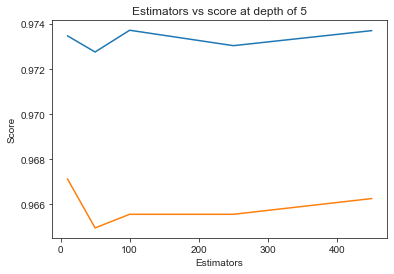

In [85]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.9557463672391018 test Score 0.9478021978021979
depth =  9 Train Score 0.9730781706130391 test Score 0.9656102494942683
depth =  11 Train Score 0.9727449707981831 test Score 0.9656102494942683
depth =  15 Train Score 0.9727449707981831 test Score 0.9656102494942683
depth =  20 Train Score 0.9727449707981831 test Score 0.9656102494942683
depth =  35 Train Score 0.9727449707981831 test Score 0.9656102494942683
depth =  50 Train Score 0.9727449707981831 test Score 0.9656102494942683
depth =  70 Train Score 0.9727449707981831 test Score 0.9656102494942683
depth =  130 Train Score 0.9727449707981831 test Score 0.9656102494942683


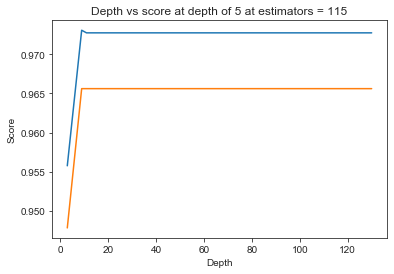

In [86]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [87]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96499392 0.97633085 0.96056116 0.96595053 0.9773331 ]
mean train scores [0.96798627 0.97983265 0.96344749 0.96974969 0.98339542]


In [88]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, n_estimators=121,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)


In [89]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [90]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [91]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9858611825192801
Test f1 score 0.9723905723905724


In [101]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt="0.2f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt="0.2f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt="0.2f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


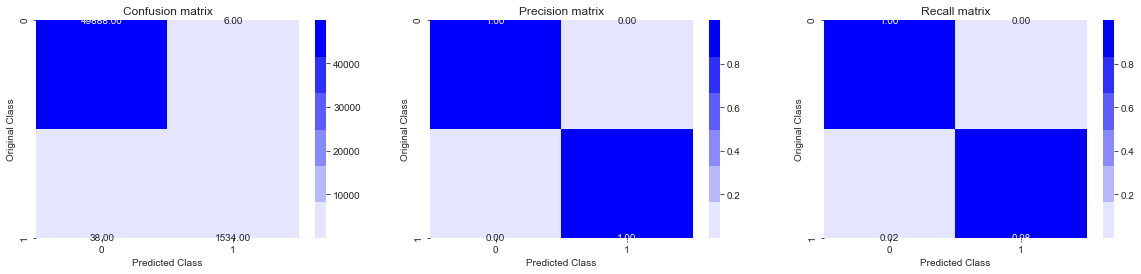

Test confusion_matrix


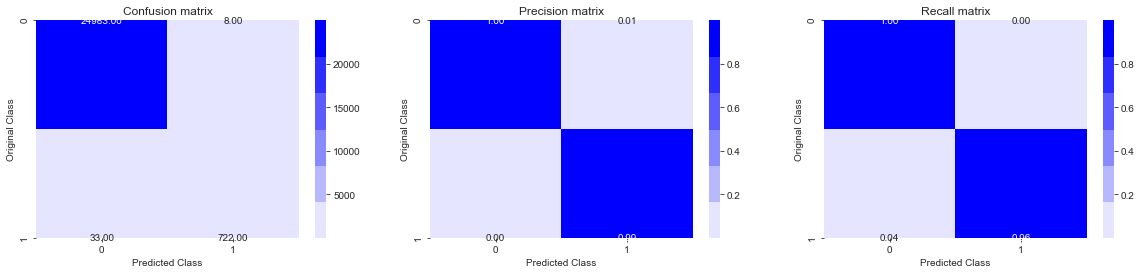

In [102]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

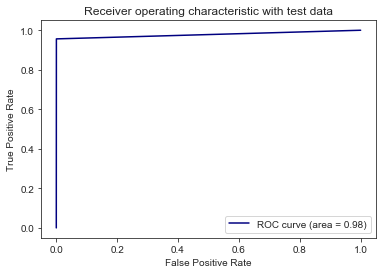

In [94]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

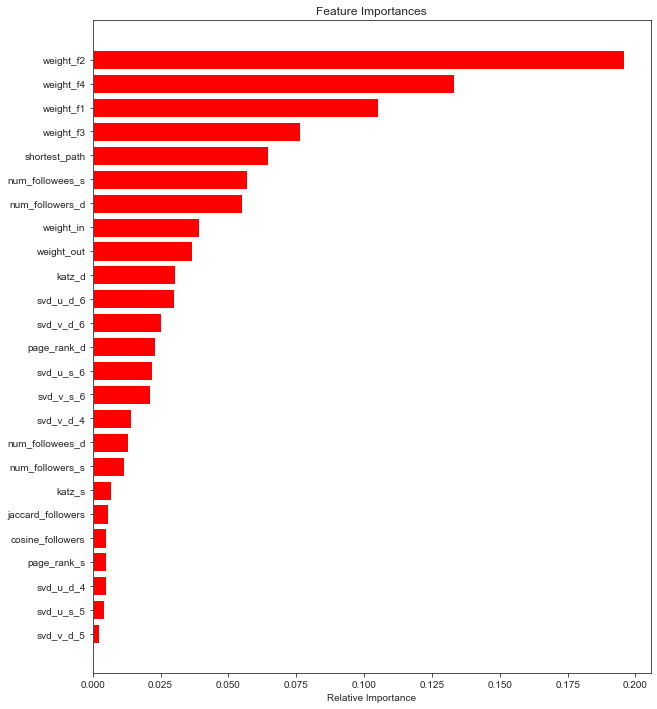

In [95]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Preferential Attachment

In [103]:
num_followers_s = list(df_final_train['num_followers_s'])
num_followers_d = list(df_final_train['num_followers_d'])
num_followees_s = list(df_final_train['num_followees_s'])
num_followees_d = list(df_final_train['num_followees_d'])

preferential_followers_train = []
for i in range(df_final_train.shape[0]):
    res = num_followers_s[i] * num_followers_d[i]
    preferential_followers_train.append(res)

preferential_followees_train = []
for i in range(df_final_train.shape[0]):
    res = num_followees_s[i] * num_followees_d[i]
    preferential_followees_train.append(res)

num_followers_s = list(df_final_test['num_followers_s'])
num_followers_d = list(df_final_test['num_followers_d'])
num_followees_s = list(df_final_test['num_followees_s'])
num_followees_d = list(df_final_test['num_followees_d'])

    
preferential_followers_test = []
for i in range(df_final_test.shape[0]):
    res = num_followers_s[i] * num_followers_d[i]
    preferential_followers_test.append(res)

preferential_followees_test = []
for i in range(df_final_test.shape[0]):
    res = num_followees_s[i] * num_followees_d[i]
    preferential_followees_test.append(res)

In [104]:
print("preferential_followers_train ",len(preferential_followers_train))
print("preferential_followees_train ",len(preferential_followees_train))
print("preferential_followers_test ",len(preferential_followers_test))
print("preferential_followees_test ",len(preferential_followees_test))

preferential_followers_train  51466
preferential_followees_train  51466
preferential_followers_test  25746
preferential_followees_test  25746


In [105]:
ss = df_final_train[['svd_u_s_1','svd_u_s_2','svd_u_s_3','svd_u_s_4','svd_u_s_5']].values
dd = df_final_train[['svd_u_d_1','svd_u_d_2','svd_u_d_3','svd_u_d_4','svd_u_d_5']].values

In [106]:
np.dot(ss[0],dd[0])

1.6949743589887096e-05

In [107]:
ss = df_final_train[['svd_u_s_1','svd_u_s_2','svd_u_s_3','svd_u_s_4','svd_u_s_5']].values
dd = df_final_train[['svd_u_d_1','svd_u_d_2','svd_u_d_3','svd_u_d_4','svd_u_d_5']].values
svd_u_dot_train = []
for i in range(df_final_train.shape[0]):
    res = np.dot(ss[i],dd[i])
    svd_u_dot_train.append(res)

ss = df_final_test[['svd_u_s_1','svd_u_s_2','svd_u_s_3','svd_u_s_4','svd_u_s_5']].values
dd = df_final_test[['svd_u_d_1','svd_u_d_2','svd_u_d_3','svd_u_d_4','svd_u_d_5']].values
svd_u_dot_test = []
for i in range(df_final_test.shape[0]):
    res = np.dot(ss[i],dd[i])
    svd_u_dot_test.append(res)
    
print("svd_dot_train ",len(svd_u_dot_train))
print("svd_dot_test ",len(svd_u_dot_test))

svd_dot_train  51466
svd_dot_test  25746


In [108]:
ss = df_final_train[['svd_v_s_1','svd_v_s_2','svd_v_s_3','svd_v_s_4','svd_v_s_5']].values
dd = df_final_train[['svd_v_d_1','svd_v_d_2','svd_v_d_3','svd_v_d_4','svd_v_d_5']].values
svd_v_dot_train = []
for i in range(df_final_train.shape[0]):
    res = np.dot(ss[i],dd[i])
    svd_v_dot_train.append(res)

ss = df_final_test[['svd_v_s_1','svd_v_s_2','svd_v_s_3','svd_v_s_4','svd_v_s_5']].values
dd = df_final_test[['svd_v_s_1','svd_v_s_2','svd_v_s_3','svd_v_s_4','svd_v_s_5']].values
svd_v_dot_test = []
for i in range(df_final_test.shape[0]):
    res = np.dot(ss[i],dd[i])
    svd_v_dot_test.append(res)
    
print("svd_dot_train ",len(svd_v_dot_train))
print("svd_dot_test ",len(svd_v_dot_test))

svd_dot_train  51466
svd_dot_test  25746


In [109]:
dataset_train = pd.DataFrame({'preferential_followers_train': preferential_followers_train, 'preferential_followees_train': preferential_followees_train,'svd_u_dot_train':svd_u_dot_train,'svd_v_dot_train':svd_v_dot_train})
dataset_test = pd.DataFrame({'preferential_followers_test': preferential_followers_test, 'preferential_followees_test': preferential_followees_test,'svd_u_dot_test':svd_u_dot_test,'svd_v_dot_test':svd_v_dot_test})

In [110]:
from scipy.sparse import hstack
X_tr = hstack((df_final_train,dataset_train))
X_te = hstack((df_final_test,dataset_test))

print("Final Data matrix on BOW")
print(X_tr.shape, y_train.shape)
# print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix on BOW
(51466, 50) (51466,)
(25746, 50) (25746,)


In [117]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import time

params = {'n_estimators' : [5, 10, 50, 100, 200, 500], 'max_depth': [1, 5, 10, 50, 100, 500]}
lgboost = lgb.LGBMClassifier(class_weight='balanced')
clf = RandomizedSearchCV(lgboost, params, cv= 3, scoring='f1',return_train_score=True,verbose=10,n_jobs=-1)
clf.fit(X_tr, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   16.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.2s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight='balanced',
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, silent=True,
                                            subsample=1.0,
                                            subsample_f

In [118]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']

In [119]:
best_params=clf.best_params_
print(best_params)

{'n_estimators': 500, 'max_depth': 50}


In [120]:
clf = lgb.LGBMClassifier(**best_params,class_weight='balanced',n_jobs=-1,verbose=10)
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 1.0
Test f1 score 0.9765258215962441


In [121]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


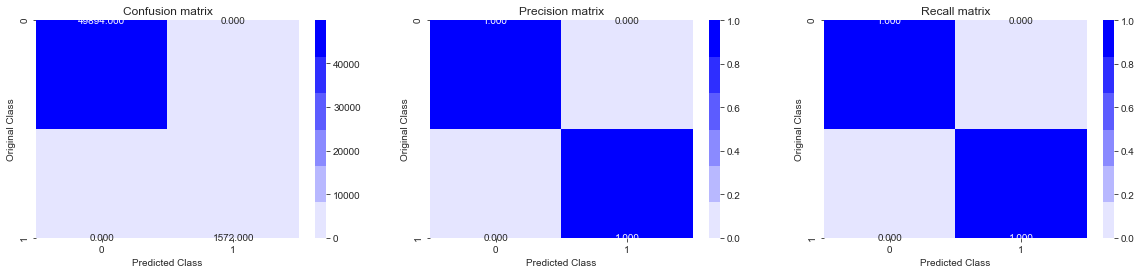

Test confusion_matrix


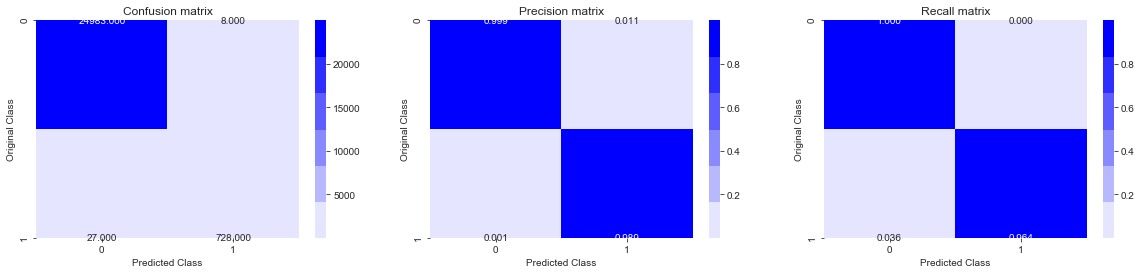

In [122]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

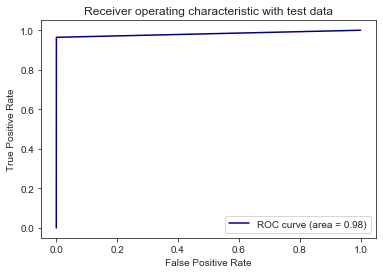

In [123]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

In [125]:
names = df_final_train.columns
names.append(dataset_train.columns)

Index(['jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'follows_back', 'shortest_path', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'svd_u_s_1', 'svd_u_s_2',
       'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1',
       'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6',
       'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5',
       'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4',
       'svd_v_d_5', 'svd_v_d_6', 'preferential_followers_train',
       'preferential_followees_train', 'svd_u_dot_train', 'svd_v_dot_train'],
      dtype='object')

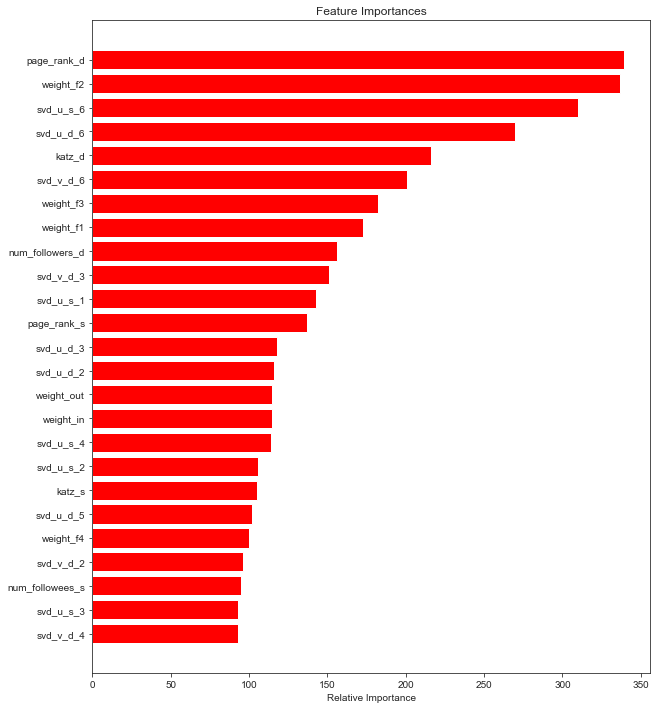

In [126]:
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [128]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = [ "Model", "Hyperparameters(max_depth,n_estimators)" , "Train F1","Test F1"] 
x.add_row([ "RF","(14,121)", 0.96,0.92]) 
x.add_row([ "GBDT After Feature Engineering", "(10,200)", 0.99,0.99])
print(x)

+--------------------------------+-----------------------------------------+----------+---------+
|             Model              | Hyperparameters(max_depth,n_estimators) | Train F1 | Test F1 |
+--------------------------------+-----------------------------------------+----------+---------+
|               RF               |                 (14,121)                |   0.96   |   0.92  |
| GBDT After Feature Engineering |                 (10,200)                |   0.99   |   0.99  |
+--------------------------------+-----------------------------------------+----------+---------+
